# Lab 5.3.2-manuf1 - Custom Object detector training using Eager Few Shot Object Detection.

This lab is based on [Eager Few Shot Object Detection Colab](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb).

---

In this lab you will fine tune a pre-trained object detection model from Tensorflow Object Detection API to predict two novel classes after initializing the model weights from a pre-trained COCO checkpoint. The training is run in [TensorFlow eager mode](https://www.youtube.com/watch?v=qTYQEXsBb_E).

**Note**: 

> This notebook was tested on a SageMaker Studio notebook using a `TensorFlow 2.10.0 Python 3.9 GPU optimized` image with a `Python 3` kernel on an `ml.g4dn.xlarge` instance type. If you cannot use a GPU instance, switch to the image `TensorFlow 2.10.0 Python 3.9 CPU optimized` with a `Python 3` kernel on an `ml.m5.xlarge` instance type.

## Setup and imports
---

First we setup the necessary variables to access all required datasets saved on Amazon S3.

In [2]:
# update pip
%pip install --root-user-action=ignore --no-warn-conflicts -q -U pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip uninstall --root-user-action=ignore -q -y setuptools
%pip install --root-user-action=ignore --no-warn-conflicts -q -U setuptools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install --root-user-action=ignore --no-warn-conflicts -q -U flake8

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

In [6]:
%%bash
# Install the Object Detection API
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install --root-user-action=ignore  --no-warn-conflicts -q .

In [7]:
!python --version

Python 3.9.16


In [8]:
import glob
import io
import os
import random

import matplotlib
import matplotlib.pyplot as plt
import imageio

import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [9]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
account_id = sagemaker_session.account_id()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

Below, we setup the name of the S3 bucket name where the data is saved.
**Make sure to update this variable if your bucket name is different.**

In [10]:
bucket_name = f"sagemaker-cv-bootcamp-{aws_region}-{account_id}"

Check if eager mode is active. More on this check in the [official documentation](https://www.tensorflow.org/api_docs/python/tf/executing_eagerly).

In [11]:
tf.executing_eagerly()

True

## Prepare dataset
---

Here we copy the data locally so that you can explore how the model fine-tuning process works interactively in this notebook.
The goal is that you start from the familiar environment of a notebook and build gradually towards migrating the training to a dedicated SageMaker Training Job.

In [12]:
!aws s3 sync --quiet s3://{bucket_name}/prepared_data/ prepared_data

In [13]:
ls prepared_data/

manifests/  train/  validation/


In [14]:
ls prepared_data/train/images/ | wc -l

480


In [15]:
ls prepared_data/validation/images/ | wc -l

60


## Helper functions
---

The following two utilities well be used to load images into numpy arrays and to plot detections results from the trained model.

In [16]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
        path: a file path.

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    use_normalized_coordinates=True):
    """Wrapper function to visualize detections.

    Args:
        image_np: uint8 numpy array with shape (img_height, img_width, 3)
        boxes: a numpy array of shape [N, 4]
        classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
        scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
        category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
        figsize: size for the figure.
        image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        min_score_thresh=0.2
    )
    if image_name:
        print(f"writing {image_name}")
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)


## Convert SageMaker Ground Truth annotations to expected format
---

We will be using the dataset with labels generated on SageMaker Ground Truth as input. Therefore, we need to make sure to process the bounding box labels to align with the format
expected by the model or training script we use. Below, we will process the labels to transform them from the format `[left, top, width, height]` to the format `[ymin, xmin, ymax, xmax]` expected by the training code. We also normalize the bounding boxes coordinates with the image height and width so they are in the range of `[0, 1]`, this improves the learning process because deep learning models use non-linear activation functions that mostly exhibit non-linearity around 0, therefore, if we use big number, like the bounding boxes coordinates, the gradient updates will be small and the learning process will be slower.

In [17]:
import json


def read_manifest_file(file_path):
    """Load manifest file."""
    with open(file_path, 'r') as f:
        output = [json.loads(line.strip()) for line in f.readlines()]
        return output


def convert_bbox_from_gt_to_coco(gt_annotation, img_width, img_height, normalize=True):
    xmin = round(gt_annotation["left"])
    ymin = round(gt_annotation["top"])
    xmax = round(gt_annotation["left"]) + round(gt_annotation["width"])
    ymax = round(gt_annotation["top"]) + round(gt_annotation["height"])

    if normalize:
        xmin = round(xmin / img_width, 7)
        ymin = round(ymin / img_height, 7)
        xmax = round(xmax / img_width, 7)
        ymax = round(ymax / img_height, 7)

    # This order is what the original colab linked above.
    bbox = [ymin, xmin, ymax, xmax]
    return bbox


def grouth_truth_manifest_to_tf_object_detection_annotations(
        ground_truth_manifest, annotation_attribute_name='cap-no-cap'
    ):
    ground_truth_manifest
    images = []
    annotations = []
    for idx, annotation in enumerate(ground_truth_manifest):
        curr_img = {}
        curr_img["id"] = idx
        curr_img["file_name"] = annotation['source-ref'].split("/")[-1]
        curr_img.update(annotation[annotation_attribute_name]['image_size'][0])
        images.append(curr_img)
        image_size = annotation[annotation_attribute_name]["image_size"][0]
        width, height = image_size["width"], image_size["height"]
        for _annotation in annotation[annotation_attribute_name]['annotations']:
            curr_annotation = {}
            curr_annotation["image_id"] = idx
            # By convention, non-background classes labels start from 1.
            curr_annotation["category_id"] = _annotation["class_id"] + 1
            curr_annotation["bbox"] = convert_bbox_from_gt_to_coco(
                _annotation, width, height
            )
            annotations.append(curr_annotation)

    return {
        "images": images,
        "annotations": annotations
    }


def write_coco_annotations(annotations, filename):
    """Write coco annotations into disk."""
    with open(filename, "w") as coco_annotation_output:
        json.dump(annotations, coco_annotation_output)


In [18]:
# Load manifest files
train_manifest_path = "prepared_data/manifests/train.manifest"
validation_manifest_path = "prepared_data/manifests/validation.manifest"

train_manifest = read_manifest_file(train_manifest_path)
validation_manifest = read_manifest_file(validation_manifest_path)

# convert from SageMaker Ground Truth format to expected coco format.
train_data_tf_od_annotations = grouth_truth_manifest_to_tf_object_detection_annotations(
    train_manifest, annotation_attribute_name='cap-no-cap'
)

validation_data_tf_od_annotations = grouth_truth_manifest_to_tf_object_detection_annotations(
    validation_manifest, annotation_attribute_name='cap-no-cap'
)

In [19]:
# Write converted annotations to disk.
write_coco_annotations(train_data_tf_od_annotations, "/tmp/train_annotations.json")
write_coco_annotations(validation_data_tf_od_annotations, "/tmp/validation_annotations.json")

Add a helper to read annotations.

In [20]:
import json

# train_annotation_json_path = "prepared_data/train/annotations.json"
train_annotation_json_path = "/tmp/train_annotations.json"

def read_annotations(annotation_json_path):
    with open(annotation_json_path) as t_an:
        annotations = json.load(t_an)
    return annotations

train_annotations = read_annotations(train_annotation_json_path)


In [21]:
train_annotations["images"][0], train_annotations["annotations"][0]

({'id': 0,
  'file_name': 'guvcview_image-141.jpg',
  'width': 640,
  'height': 480,
  'depth': 3},
 {'image_id': 0,
  'category_id': 1,
  'bbox': [0.4645833, 0.4203125, 0.7229167, 0.61875]})

## Load training dataset
---

In [22]:
# Load images and visualize
import glob
import os

def load_images(image_dir, annotations):
    np_images_list = []
    n_images = len(annotations["images"])
    print(f"Number of images to load is {n_images}")
    for idx, _img in enumerate(annotations["images"]):
        img_path = os.path.join(image_dir, _img["file_name"])
        # load images as numpy arrays and append to the list.
        np_images_list.append(load_image_into_numpy_array(img_path))
        if idx and idx % 50 == 0:
            print(f"Loaded {idx} images")
    return np_images_list

In [23]:
%%time
train_image_dir = "prepared_data/train/images"
train_images_np = load_images(train_image_dir, train_annotations)

Number of images to load is 560
Loaded 50 images
Loaded 100 images
Loaded 150 images
Loaded 200 images
Loaded 250 images
Loaded 300 images
Loaded 350 images
Loaded 400 images
Loaded 450 images
Loaded 500 images
Loaded 550 images
CPU times: user 1min 31s, sys: 7.42 s, total: 1min 38s
Wall time: 1min 39s


Add a helper to parse classes and boudning boxes from annotations data and run it on training annotations

In [24]:
def get_classes_and_bboxes(annotations):
    ground_truth_bboxes = []
    class_ids = []
    for ann in annotations["annotations"]:
        ground_truth_bboxes.append(np.array([ann["bbox"]]))
        class_ids.append(ann["category_id"])
    return ground_truth_bboxes, class_ids

train_bboxes, train_gt_classes = get_classes_and_bboxes(train_annotations)

In [25]:
train_gt_classes[:10]

[1, 2, 1, 1, 2, 2, 1, 2, 1, 2]

Visualize a sample of input data

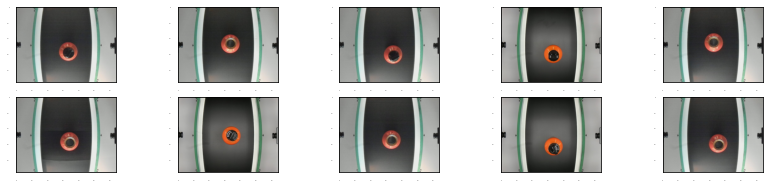

In [26]:
# Not required in script mode.
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 8]

for idx, train_image_np in enumerate(train_images_np[:10]):
    plt.subplot(5, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

# Prepare data for training

Below we add the class annotations.  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [27]:
%%time
# By convention, our non-background classes start counting at 1.
cap_class_id = 1
nocap_class_id = 2
num_classes = 2

category_index = {
    cap_class_id: {'id': cap_class_id, 'name': 'cap'},
    nocap_class_id: {'id': nocap_class_id, 'name': 'nocap'}
}

def prepare_data(num_classes, images_np, bboxes, ground_truth_classes):
    # Convert class labels to one-hot; convert everything to tensors.
    # The `label_id_offset` here shifts all classes by a certain number of indices;
    # we do this here so that the model receives one-hot labels where non-background
    # classes start counting at the zeroth index.  This is ordinarily just handled
    # automatically in our training binaries, but we need to reproduce it here.
    label_id_offset = 1
    image_tensors = []
    gt_classes_one_hot_tensors = []
    gt_bbox_tensors = []

    for (image_np, gt_bbox_np, gt_class_np) in zip(images_np, bboxes, ground_truth_classes):
        # Convert image numpy array into a tensor, with dtype=tf.float32,
        # and inserts a length 1 axis at index axis=0
        image_tensors.append(
            tf.expand_dims(tf.convert_to_tensor(image_np, dtype=tf.float32), axis=0)
        )
        # Convert bbox numpy array into a tensor, with dtype=tf.float32,
        # and inserts a length 1 axis at index axis=0
        gt_bbox_tensors.append(tf.convert_to_tensor(gt_bbox_np, dtype=tf.float32))

        # Convert bbox numpy array into a tensor, with dtype=tf.int32,
        # and substract the label id offset `label_id_offset`.
        zero_indexed_groundtruth_classes = tf.convert_to_tensor(
            gt_class_np - label_id_offset, dtype=tf.int32
        )

        # Convert zero_indexed_groundtruth_classes to one-hot tensor
        gt_classes_one_hot_tensors.append(
            tf.expand_dims(tf.one_hot(zero_indexed_groundtruth_classes, num_classes), axis=0)
        )

    return image_tensors, gt_bbox_tensors, gt_classes_one_hot_tensors


train_image_tensors, gt_bbox_tensors, gt_classes_one_hot_tensors = (
    prepare_data(num_classes, train_images_np, train_bboxes, train_gt_classes)
)

print('Done prepping data.')

Done prepping data.
CPU times: user 1.55 s, sys: 997 ms, total: 2.55 s
Wall time: 2.65 s


In [28]:
gt_classes_one_hot_tensors[:10]

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>]

# Let's visualize some images as a sanity check


Pick up a sample of images randomly and visualize them alongside their bounding boxes. Note that the score is fake.

In [29]:
category_index

{1: {'id': 1, 'name': 'cap'}, 2: {'id': 2, 'name': 'nocap'}}

In [30]:
train_bboxes[0].shape

(1, 4)

In [31]:
# Not required in training script
import random
pick_6_random_images = random.sample(range(len(train_images_np)), 6)
pick_6_random_images

[46, 140, 247, 289, 133, 341]

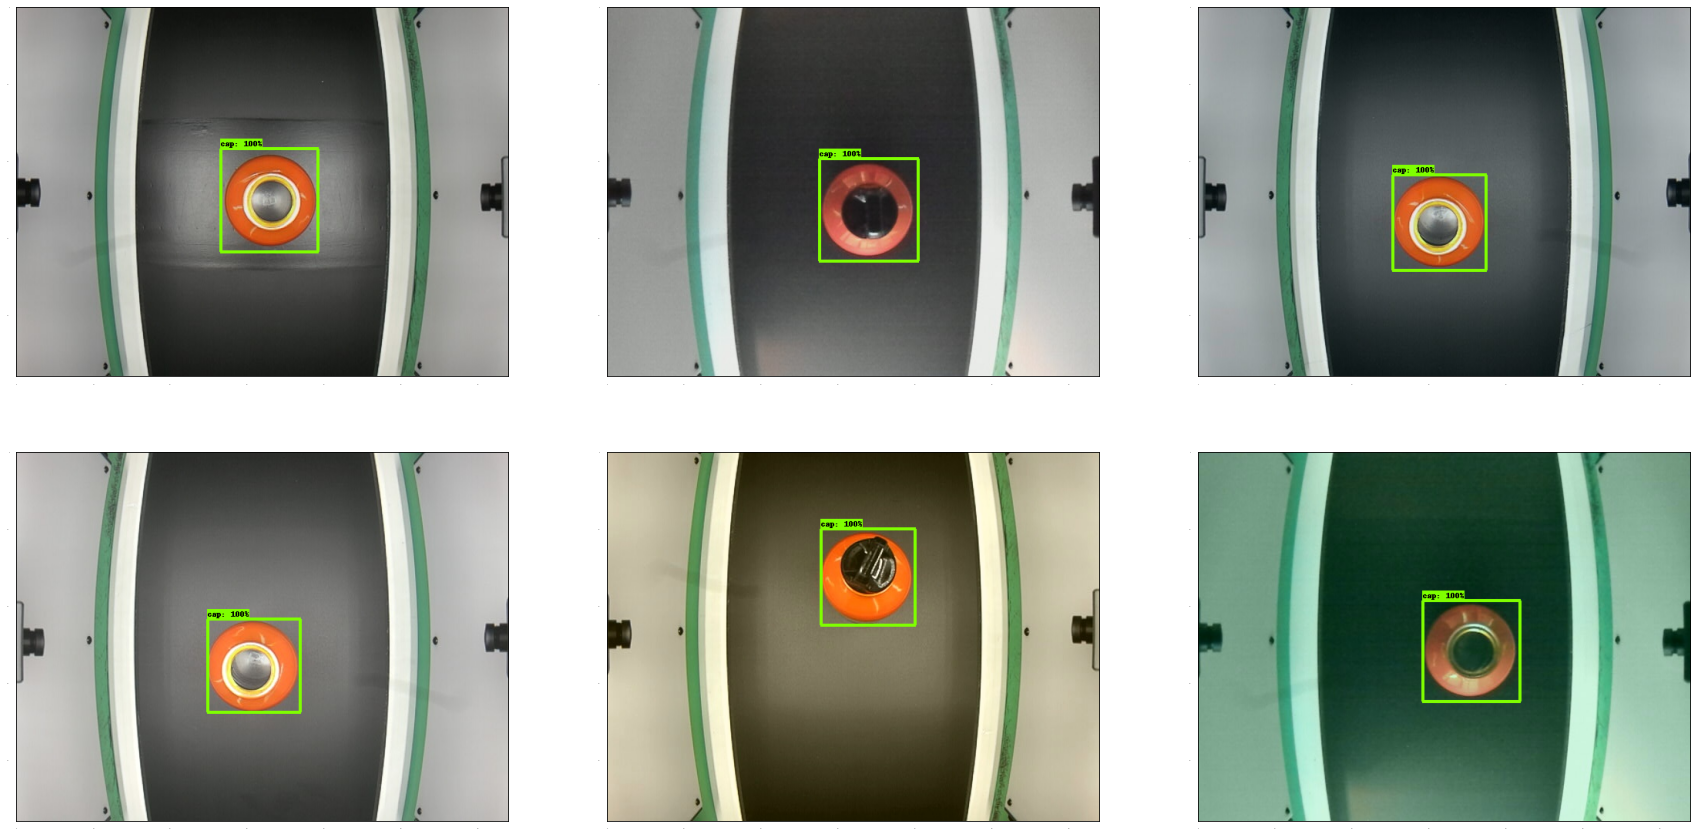

In [32]:
# Not required in training script
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx, img_indx in enumerate(pick_6_random_images):
    plt.subplot(2, 3, idx+1)
    plot_detections(
      train_images_np[img_indx],
      train_bboxes[img_indx],
      np.ones(shape=[train_bboxes[img_indx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build the pre-trained model and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this notebook, including assuming that the image size will always be 640x640, however it is not difficult to generalize to other model configurations.

Next download the model. The following command will download only if the model file does not exist locally.

In [33]:
# -nc to skip download if file exists -> https://stackoverflow.com/questions/4944295/skip-download-if-files-already-exist-in-wget
!wget -nc http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# Download and put in a path in S3.

File ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ already there; not retrieving.



In [34]:
import tarfile


def load_and_prepare_model(input_model_path, num_classes, model_dir, pipeline_config_file_path, checkpoint_path):
    """Untar the pretrained model and load it into memory.

    Returns the loaded model along with configs, pipeline_config_file_path and the image size.
    """

    # ------------------------  extract model files  ------------------------------
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    with tarfile.open(input_model_path, "r") as saved_model_tar:
        # the model will be extracted to a folder named with the model name
        saved_model_tar.extractall(model_dir)

    model_name = input_model_path.split(".")[0]
    model_dir = os.path.join(model_dir, model_name)

    tf.keras.backend.clear_session()

    # ------- Load pipeline config and build a detection model. --------------

    # Build the model from config files using the object_detection package.
    pipeline_config_file_path = os.path.join(
        model_dir,
        "pipeline.config"
    )

    checkpoint_path = os.path.join(model_dir, "checkpoint/ckpt-0")
    configs = config_util.get_configs_from_pipeline_file(pipeline_config_file_path)

    model_config = configs["model"]
    model_config.ssd.num_classes = num_classes
    model_config.ssd.freeze_batchnorm = True
    detection_model = model_builder.build(model_config=model_config, is_training=True)

    # ------------- Set up object-based checkpoint restore  ------------------
    # --- Models has two prediction
    # `heads` --- one for classification, the other for box regression.  We will
    # restore the box regression head but initialize the classification head
    # from scratch (we show the omission below by commenting out the line that
    # we would add if we wanted to restore both heads)

    fake_box_predictor = tf.compat.v2.train.Checkpoint(
        _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
        # _prediction_heads=detection_model._box_predictor._prediction_heads,
        #    (i.e., the classification head that we *will not* restore)
        _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

    fake_model = tf.compat.v2.train.Checkpoint(
        _feature_extractor=detection_model._feature_extractor,
        _box_predictor=fake_box_predictor
    )

    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(checkpoint_path).expect_partial()

    # ----  Run model through a dummy image so that variables are created ----
    # image_size = get_image_size(input_model_untarred_path=model_dir)
    image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
    prediction_dict = detection_model.predict(image, shapes)
    detection_model.postprocess(prediction_dict, shapes)

    return detection_model, configs, pipeline_config_file_path


In [35]:
import tempfile
import shutil

# Path to the compressed file containing the pre-trained model.
input_model_path = "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz"
num_classes = 2
# Directory where to extract the pretrained model.
model_dir = os.path.join(tempfile.mkdtemp(), "model")
pipeline_config_file_path = "models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"
checkpoint_path = "checkpoint/ckpt-0"

In [36]:
# later cleanup temp model directory shutil.rmtree(model_dir)

Now, we load and prepare the model for training using the helpers above

In [37]:
%%time
detection_model, configs, pipeline_config_file_path = load_and_prepare_model(
    input_model_path, num_classes, model_dir, pipeline_config_file_path, checkpoint_path
)

CPU times: user 6.29 s, sys: 1.41 s, total: 7.69 s
Wall time: 7.72 s


# Eager mode custom training loop

Here we setup the training loop.

The helper below creates a function that runs a single training step.

In [38]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune, batch_size):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):
        """A single training iteration.

        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        # shapes = [tf.constant([640, 640, 3], dtype=tf.int32) for _ in range(batch_size)]
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
              [detection_model.preprocess(image_tensor)[0]
               for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss, losses_dict['Loss/localization_loss'], losses_dict['Loss/classification_loss']

    return train_step_fn

The following function iterates and trains over the full training set.

In [39]:
def train(detection_model, train_images_np, gt_bbox_tensors, gt_classes_one_hot_tensors, train_image_tensors, batch_size, learning_rate, num_batches, output_model_dir):
    tf.keras.backend.set_learning_phase(True)
    # Select variables in top layers to fine-tune.
    trainable_variables = detection_model.trainable_variables
    to_fine_tune = []
    prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
    for var in trainable_variables:
        if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
            to_fine_tune.append(var)

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    train_step_fn = get_model_train_step_function(
        detection_model, optimizer, to_fine_tune, batch_size
    )

    best_loss_so_far = np.inf

    # To save checkpoint for TFLite conversion.
    exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)

    export_path = os.path.join(output_model_dir, "checkpoint")
    ckpt_manager = tf.train.CheckpointManager(
        exported_ckpt, export_path, checkpoint_name="ckpt", max_to_keep=1
    )

    print('Start fine-tuning!', flush=True)
    for idx in range(num_batches):
        # Grab keys for a random subset of examples
        all_keys = list(range(len(train_images_np)))
        random.shuffle(all_keys)
        example_keys = all_keys[:batch_size]

        gt_bboxes_list = [gt_bbox_tensors[key] for key in example_keys]
        gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
        image_tensors = [train_image_tensors[key] for key in example_keys]
        # Training step (forward pass + backwards pass)
        total_loss, localization_loss, classification_loss = train_step_fn(
        image_tensors, gt_bboxes_list, gt_classes_list
        )

        if idx % 10 == 0:
            print(
                f"batch {idx} of {num_batches}, loss={total_loss.numpy()}, "
                f"localization_loss={localization_loss.numpy()}, "
                f"classification_loss={classification_loss.numpy()}",
                flush=True
            )
        if total_loss < best_loss_so_far:
            best_loss_so_far = total_loss
            print(f"Saving checkpoint with loss {best_loss_so_far}")
            ckpt_manager.save(0)
            print("Done saving")

    print('Done fine-tuning!')
    return detection_model

In [40]:
saved_model_dir = "./saved_tf_od_manuf1_model"

Below we trigger the training process.

In [41]:
%%time

# Increase the batch size if you need to fit more images in memory.
batch_size = 32
learning_rate = 0.01
num_batches = 200

detection_model = train(
    detection_model,
    train_images_np,
    gt_bbox_tensors,
    gt_classes_one_hot_tensors,
    train_image_tensors,
    batch_size,
    learning_rate,
    num_batches,
    saved_model_dir
)

Start fine-tuning!


/usr/local/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


batch 0 of 200, loss=1.3051142692565918, localization_loss=0.1669297218322754, classification_loss=1.1381845474243164
Saving checkpoint with loss 1.3051142692565918
Done saving
Saving checkpoint with loss 1.1844090223312378
Done saving
Saving checkpoint with loss 0.9167031049728394
Done saving
Saving checkpoint with loss 0.624190628528595
Done saving
Saving checkpoint with loss 0.6205456256866455
Done saving
Saving checkpoint with loss 0.5467740297317505
Done saving
Saving checkpoint with loss 0.4484788477420807
Done saving
Saving checkpoint with loss 0.41547662019729614
Done saving
batch 10 of 200, loss=0.43156296014785767, localization_loss=0.10966496169567108, classification_loss=0.3218979835510254
Saving checkpoint with loss 0.3654526472091675
Done saving
Saving checkpoint with loss 0.28744688630104065
Done saving
Saving checkpoint with loss 0.27900412678718567
Done saving
Saving checkpoint with loss 0.27088993787765503
Done saving
batch 20 of 200, loss=0.32306814193725586, localiz

# Load test images and run inference with new model!

Once the model is trained, we can test the inference results on an image from the validation set as outlined below.

In [42]:
!mkdir -p demo

In [43]:
%%time
tf.keras.backend.set_learning_phase(False)
test_image_dir = 'prepared_data/validation/images'
test_images_np = []
test_images = glob.glob(os.path.join(test_image_dir, "*"))
test_images = test_images[:20]

# test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
for image_path in test_images:
  # image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
num_detections_to_keep = 1

label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)

    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0][:num_detections_to_keep].numpy(),
        detections['detection_classes'][0][:num_detections_to_keep].numpy().astype(np.uint32) + label_id_offset,
        detections['detection_scores'][0][:num_detections_to_keep].numpy(),
        category_index,
        figsize=(15, 20),
        image_name="demo/gif_frame_" + ('%02d' % i) + ".jpg"
    )

Cause: Unable to locate the source code of <function detect at 0x7efec569c940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function detect at 0x7efec569c940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function detect at 0x7efec569c940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
writing demo/gif_frame_00.jpg
writing demo/gif_frame_01.jpg
writing demo/gif_frame_02.jpg
writing demo/gif_frame_03.jpg
writing demo/gif_frame_04.jpg
writing demo/gif_frame_05.jpg
writing demo/gif_frame_06.jpg
writing demo/gif_frame_07.jpg
writing demo/gif_frame_08.jpg
writing demo/gif_frame_09.jpg
writing demo/gif_frame_10.jpg
writing demo/gif_frame_11.jpg
writing demo/gif_frame_12.jpg
writing demo/gif_frame_13.jpg
writing demo/gif_frame_14.jpg
writing demo/gif_frame_15.jpg
writi

We can combine the images with predicted bounding boxes to produce a video-like git showcasing the results of object detection.

<timed exec>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


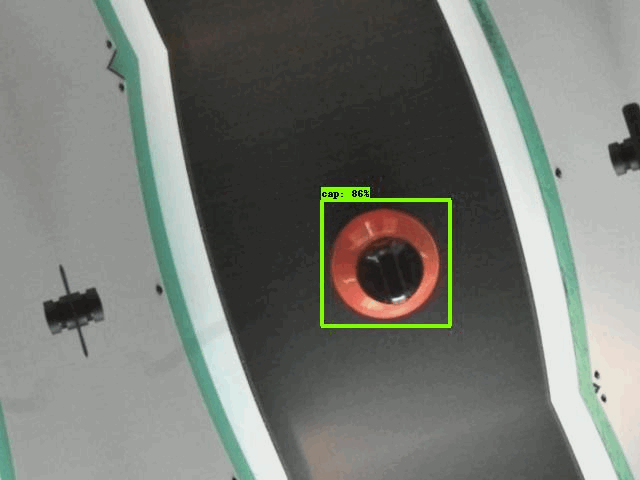

CPU times: user 684 ms, sys: 29.3 ms, total: 713 ms
Wall time: 955 ms


In [44]:
%%time

imageio.plugins.freeimage.download()

anim_file = 'demo/capnocap_test.gif'

filenames = glob.glob('demo/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=1)

display(IPyImage(open(anim_file, 'rb').read()))

## Save trained model

The training process above saved model checkpoints each time the loss improved.
The following helper adds the corresponding TensorFlow Object Detection pipeline config file and converts
the model into `saved_model` format to convert later for use on the edge device.

In [45]:
from pathlib import Path


def save_finetuned_model(configs, saved_model_dir, class_to_idx):
    # Inference scripts requires the model in the SavedModel format and training loads/saves in checkpoint format.
    # Thus, we use the utility from object_detection package to convert the checkpoint format model to SavedModel format.
    
    # export_command = 'export PYTHONPATH="${PYTHONPATH}:' + str(Path.cwd()) + '"'
    # print(export_command)

    # Save auxiliary files with the model.
    pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
    config_util.save_pipeline_config(pipeline_proto, saved_model_dir)

    os.system(
        f"python models/research/object_detection/exporter_main_v2.py --input_type image_tensor "
        f"--trained_checkpoint_dir {os.path.join(saved_model_dir,'checkpoint')} "
        f"--output_directory {saved_model_dir} "
        f"--pipeline_config_path {os.path.join(saved_model_dir,'pipeline.config')}"
    )

    # Inference expects the saved_model dir to be named 1 and conversion script above saves the model in the directory
    # named saved_model. Thus, we change the directory name.
    os.system(f"mv {saved_model_dir}/saved_model {saved_model_dir}/1")

    # utils.save_model_info(input_model_untarred_path=constants.INPUT_MODEL_UNTARRED_PATH, model_dir=args.model_dir)

    with open(os.path.join(saved_model_dir, "labels_info.json"), "w") as nf:
        idx_to_labels = {idx: label for label, idx in class_to_idx.items()}
        labels = [idx_to_labels[idx] if idx in idx_to_labels else "N/A" for idx in range(max(idx_to_labels) + 1)]
        # logging.info("Labels info file content")
        # logging.info(json.dumps({constants.LABELS: labels}, indent=4))
        nf.write(json.dumps({"labels": labels}))

    return True


In [46]:
%%time
class_to_idx = {'cap': 1, 'no-cap': 2}
save_finetuned_model(configs, saved_model_dir, class_to_idx)

INFO:tensorflow:Writing pipeline config file to ./saved_tf_od_manuf1_model/pipeline.config


INFO:tensorflow:Writing pipeline config file to ./saved_tf_od_manuf1_model/pipeline.config


CPU times: user 12.8 ms, sys: 12.1 ms, total: 24.8 ms
Wall time: 55.6 s


True

In [47]:
!ls -alh {saved_model_dir}

total 32K
drwxr-xr-x  5 root root 6.0K Apr 20 14:40 .
drwxr-xr-x 12 root root 6.0K Apr 20 14:39 ..
drwxr-xr-x  5 root root 6.0K Apr 20 13:49 1
drwxr-xr-x  2 root root 6.0K Apr 20 14:41 checkpoint
-rw-r--r--  1 root root   36 Apr 20 14:41 labels_info.json
-rw-r--r--  1 root root 4.2K Apr 20 14:41 pipeline.config
drwxr-xr-x  4 root root 6.0K Apr 20 14:41 saved_model


In [48]:
!ls -alh {saved_model_dir}/checkpoint

total 122M
drwxr-xr-x 2 root root 6.0K Apr 20 14:41 .
drwxr-xr-x 5 root root 6.0K Apr 20 14:40 ..
-rw-r--r-- 1 root root  166 Apr 20 14:40 checkpoint
-rw-r--r-- 1 root root 122M Apr 20 14:40 ckpt-0.data-00000-of-00001
-rw-r--r-- 1 root root  31K Apr 20 14:40 ckpt-0.index


In [49]:
!ls -alh {saved_model_dir}/1/

total 6.7M
drwxr-xr-x 5 root root 6.0K Apr 20 13:49 .
drwxr-xr-x 5 root root 6.0K Apr 20 14:40 ..
drwxr-xr-x 2 root root 6.0K Apr 19 13:07 assets
drwxr-xr-x 4 root root 6.0K Apr 20 13:49 saved_model
-rw-r--r-- 1 root root 6.7M Apr 19 13:07 saved_model.pb
drwxr-xr-x 2 root root 6.0K Apr 19 13:07 variables


In [50]:
!du -h {saved_model_dir}/1/

122M	./saved_tf_od_manuf1_model/1/variables
4.0K	./saved_tf_od_manuf1_model/1/assets
122M	./saved_tf_od_manuf1_model/1/saved_model/variables
4.0K	./saved_tf_od_manuf1_model/1/saved_model/assets
128M	./saved_tf_od_manuf1_model/1/saved_model
256M	./saved_tf_od_manuf1_model/1/


## Refactor the training code into a training script
----

In order to run a training as job using SageMaker Training Jobs, you need to put your training process into a python script,
that we will call training script.

We save the training script into the `src` folder. This helps for organizing the code, but also allows us to ship 
other dependencies and scripts with the main training script, including a `requirements.txt` file contains any, pip installable, dependencies
you want SageMaker to install before running the script.

> Discuss with your instructor to clarify any ambiguities your have.

In [51]:
!pygmentize train/custom_object_detection_training.py

import argparse
import json
import logging
import os
import random
import sys
import tarfile

import numpy as np
from six import BytesIO
from pathlib import Path
from PIL import Image
import tensorflow as tf

from utils import extract_object_detection_lib

# setting up tensorflow object detection api from tar.gz file
EXTRA_DEPENDENCIES_PATH = "/opt/ml/code/lib/extra_dependencies"
TF_OBJECT_DETECTION_TAR_BALL = "tf_object_detection.tar.gz"

extract_object_detection_lib(
    os.path.join(EXTRA_DEPENDENCIES_PATH, TF_OBJECT_DETECTION_TAR_BALL), "."
)

from object_detection.utils import config_util
from object_detection.builders import model_builder

root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
root.addHandler(handler)

logging.info(tf.config.list_physical_devices("GPU"))
logging.info("Below is the nvcc version")
os.system("nvcc --version")
logging.info("Below is nvidia-smi output")
os.system("nvidia-smi")


def load_image_into_numpy_arr

We run the open source library flake8, which is a static code analyzer, to catch any errors in the code before
triggering the job. This save on debugging time.

In [52]:
!flake8 --max-line-length=120 --ignore=E402 train/custom_object_detection_training.py

train/custom_object_detection_training.py:422:1: W293 blank line contains whitespace


## Run the training script using a SageMaker Training Job
----

In [53]:
import os
import numpy as np
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
account_id = sagemaker_session.account_id()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

In [54]:
bucket_name = f"sagemaker-cv-bootcamp-{aws_region}-{account_id}"

We put the pre-trained model on S3 to provide it as an input to the training job

In [55]:
!wget -nc http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

File ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ already there; not retrieving.



In [56]:
!aws s3 cp ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz s3://{bucket_name}/pre-trained-models/

upload: ./ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz to s3://sagemaker-cv-bootcamp-us-east-2-<AWS_ACCOUNT_ID>/pre-trained-models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz


In [57]:
!aws s3 ls s3://{bucket_name}/pre-trained-models/

2023-04-20 14:41:07  244817203 ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz


In [58]:
model_filename = "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz"

In [59]:
!mkdir -p src/lib/extra_dependencies/
!cp tf_object_detection.tar.gz src/lib/extra_dependencies/tf_object_detection.tar.gz

### Run training using SageMaker Training Job

Setup a SageMaker Training Job to run your script. This requires:

1. Identify the appropriate framework to use, in this case `TensorFlow`.
2. Get the image uri of the pre-built container to use for training.
3. Setting up an Estimator, which essential holds the configurations of the training job to run.
4. Prepare the training inputs.
5. Then run the fit method to start the training job.

In [60]:
%pip install --root-user-action=ignore --no-warn-conflicts -q sagemaker==2.140.1

Note: you may need to restart the kernel to use updated packages.


In [61]:
ls src/lib/extra_dependencies/

tf_object_detection.tar.gz


In [62]:
import boto3
from sagemaker import image_uris

# training_instance_type = "ml.p3.2xlarge"
training_instance_type = "ml.g4dn.4xlarge"
# training_instance_type = "ml.m5.xlarge"
region_name =  boto3.session.Session().region_name
# model version can be found in
# https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html
# available images: https://github.com/aws/deep-learning-containers/blob/master/available_images.md
# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=region_name,
    framework="tensorflow",
    version="2.10",
    image_scope="training",
    instance_type=training_instance_type
)
train_image_uri

'763104351884.dkr.ecr.us-east-2.amazonaws.com/tensorflow-training:2.10-gpu-py39'

In [63]:
hyperparameters = {
    "batch_size": "32",
    # "reinitialize_top_layer": "Auto",
    # "train_only_top_layer": "False",
    # "optimizer": "adam",
    # "learning_rate": "0.001",
    # "beta_1": "0.9",
    # "beta_2": "0.999",
    # "momentum": "0.9",
    # "epsilon": "1e-07",
    # "rho": "0.95",
    # "initial_accumulator_value": "0.1",
    # "early_stopping": "False",
    # "early_stopping_patience": "5",
    # "early_stopping_min_delta": "0.0",
    # "epochs": "1"
}

In [64]:
%%time
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"cv-bootcamp-manuf1-model")

training_metric_definitions = [
    {"Name": "val_localization_loss", "Regex": "Val_localization=([0-9\\.]+)"},
    {"Name": "val_classification_loss", "Regex": "Val_classification=([0-9\\.]+)"},
    {"Name": "train_loss", "Regex": "loss=([0-9\\.]+)."},
]

# Create SageMaker Estimator instance
eager_tf_od_estimator = Estimator(
    entry_point="custom_object_detection_training.py",
    source_dir="train/",
    role=aws_role,
    image_uri=train_image_uri,
    model_uri=f"s3://{bucket_name}/pre-trained-models/{model_filename}",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=f"s3://{bucket_name}/manuf1-model/output/",
    base_job_name=training_job_name,
    metric_definitions=training_metric_definitions,
)

CPU times: user 71.8 ms, sys: 20.5 ms, total: 92.3 ms
Wall time: 101 ms


In [65]:
from sagemaker.inputs import TrainingInput

In [66]:
train_dataset_s3_path = f"s3://{bucket_name}/prepared_data/train/"
validation_dataset_s3_path = f"s3://{bucket_name}/prepared_data/validation/"
manifests_dataset_s3_path = f"s3://{bucket_name}/prepared_data/manifests/"

In [67]:
!aws s3 ls {manifests_dataset_s3_path}

2023-04-19 12:41:39       5625 test.manifest
2023-04-19 12:41:39     326102 train.manifest
2023-04-19 12:41:39      40814 validation.manifest


In [68]:
training_data_input = TrainingInput(
    s3_data=train_dataset_s3_path
)

validation_data_input = TrainingInput(
    s3_data=validation_dataset_s3_path
)

manifests_data_input = TrainingInput(
    s3_data=manifests_dataset_s3_path
)

In [69]:
%%time
# Launch a SageMaker Training job by passing s3 path of the training data
eager_tf_od_estimator.fit({
    "train": training_data_input,
    "validation": validation_data_input,
    "manifests": manifests_dataset_s3_path,
}, logs=False, wait=False)

CPU times: user 130 ms, sys: 16.1 ms, total: 146 ms
Wall time: 693 ms
